## csv 로드 및 dataset 설정

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageFilter
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [6]:
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    return df

## 전처리 과정 

In [9]:
import os
print(os.getcwd())  # 현재 작업 디렉토리 확인


/Users/skku_aws19/Desktop/aws_project/pre-project/model


총 이미지 수: 10


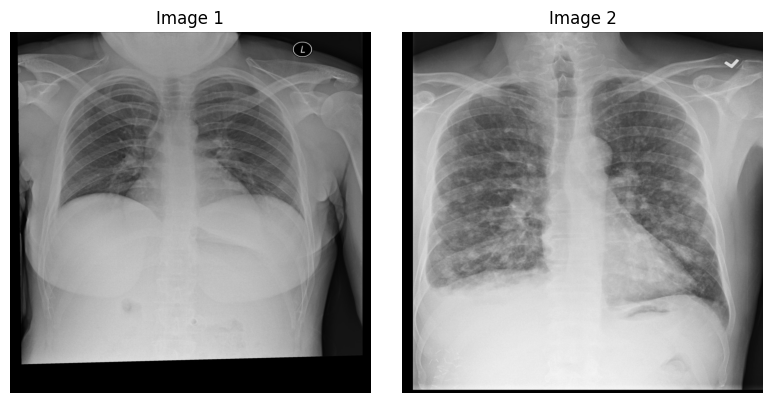

In [13]:
image_paths = sorted(glob.glob('/Users/skku_aws19/Desktop/aws_project/pre-project/data/train/*.jpg'))[:10]
print(f"총 이미지 수: {len(image_paths)}")
plt.figure(figsize=(8, 4))
for i in range(2):
    img = Image.open(image_paths[i]).convert("RGB")  # ← 여기 중요
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### grayscale 변환

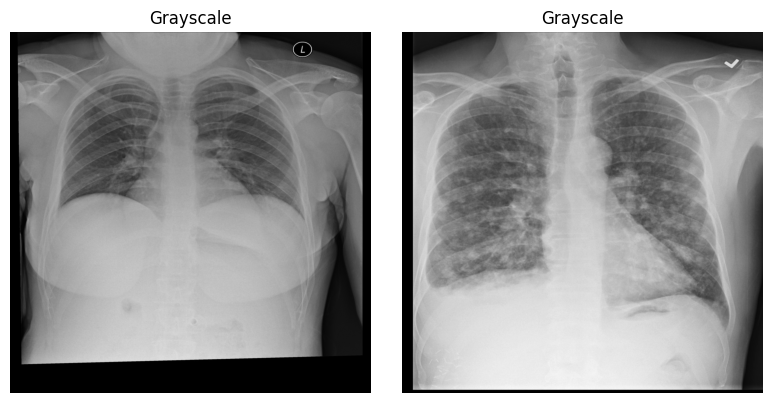

In [11]:
gray_images = []

for path in image_paths:
    img = Image.open(path).convert("L")  # L mode = Grayscale
    gray_images.append(img)

# 결과 확인 (앞에서 2장)
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(gray_images[i], cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')
plt.tight_layout()
plt.show()


### 히스토그램 평활화(CLAHE)

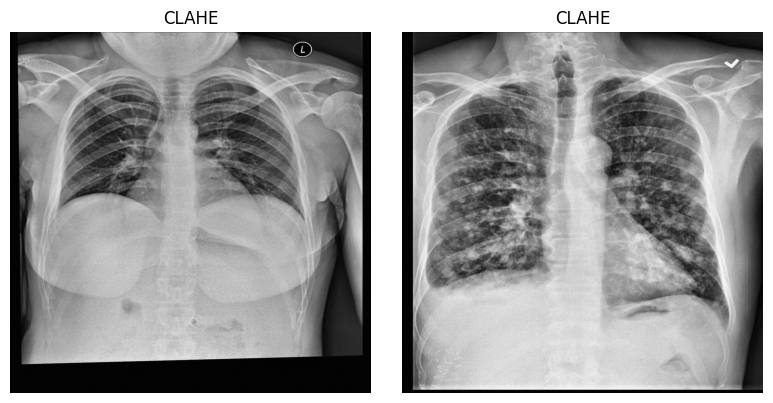

In [14]:
clahe_images = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for img in gray_images:
    np_img = np.array(img)
    equalized = clahe.apply(np_img)
    clahe_images.append(Image.fromarray(equalized))

# 결과 확인
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(clahe_images[i], cmap='gray')
    plt.title("CLAHE")
    plt.axis('off')
plt.tight_layout()
plt.show()


### 가우시안 필터

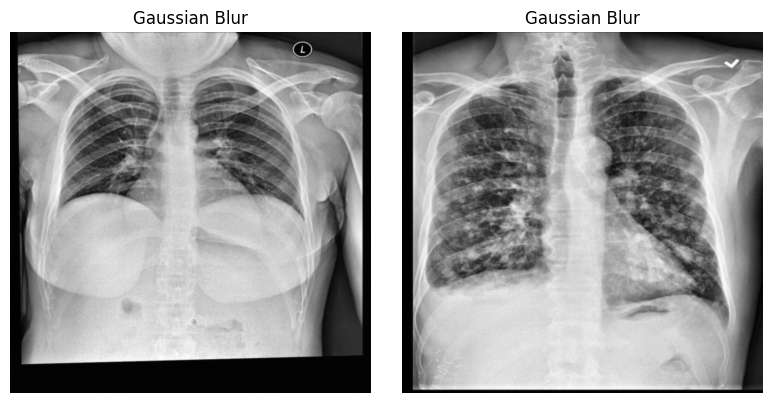

In [15]:
blurred_images = []

for img in clahe_images:
    blurred = img.filter(ImageFilter.GaussianBlur(radius=1.0))
    blurred_images.append(blurred)

# 결과 확인
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(blurred_images[i], cmap='gray')
    plt.title("Gaussian Blur")
    plt.axis('off')
plt.tight_layout()
plt.show()


### 샤프닝 필터

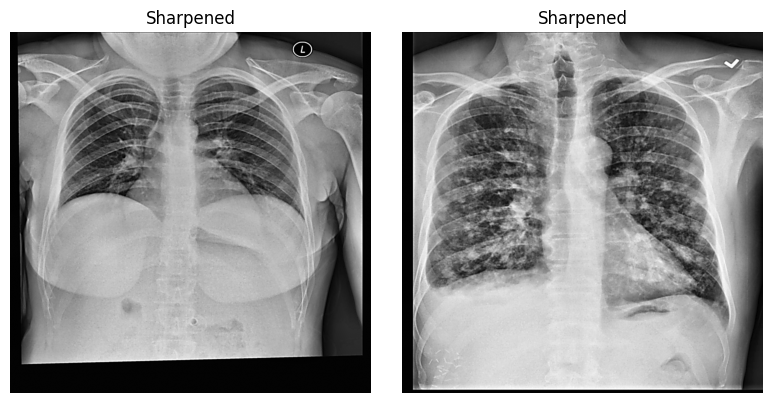

In [16]:
sharpened_images = []

for img in blurred_images:
    sharpened = img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
    sharpened_images.append(sharpened)

# 결과 확인
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(sharpened_images[i], cmap='gray')
    plt.title("Sharpened")
    plt.axis('off')
plt.tight_layout()
plt.show()

### rgb로 전환

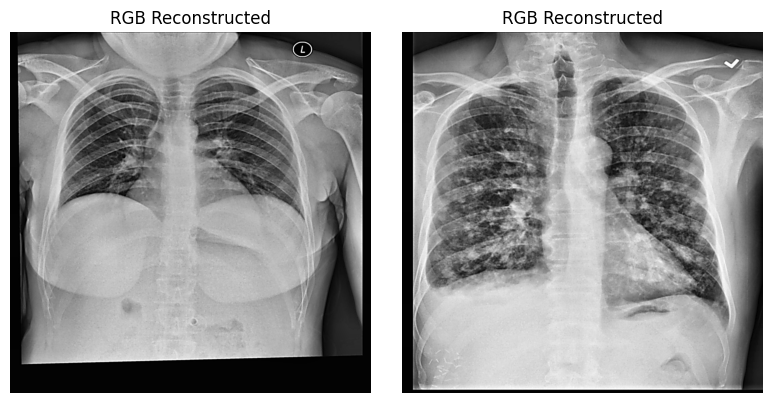

In [17]:
rgb_images = []

for img in sharpened_images:
    rgb_img = Image.merge("RGB", (img, img, img))  # Grayscale 3채널 복사
    rgb_images.append(rgb_img)

# 결과 확인
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(rgb_images[i])
    plt.title("RGB Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 전체 이미지 전처리 

In [18]:
# 원본 이미지 폴더 및 저장 폴더 설정
input_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/train'
output_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/train_preprocessed'

os.makedirs(output_dir, exist_ok=True)

# 이미지 경로 리스트
image_paths = sorted(glob.glob(os.path.join(input_dir, '*.jpg')))
print(f"총 이미지 수: {len(image_paths)}")

총 이미지 수: 18679


In [ ]:
# CLAHE 설정
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for i, path in enumerate(image_paths):
    filename = os.path.basename(path)

    # 1. Load and Grayscale
    img = Image.open(path).convert("L")  # Grayscale

    # 2. CLAHE
    np_img = np.array(img)
    equalized = clahe.apply(np_img)
    img_eq = Image.fromarray(equalized)

    # 3. Gaussian Blur
    img_blur = img_eq.filter(ImageFilter.GaussianBlur(radius=1.0))

    # 4. Sharpening
    img_sharp = img_blur.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))

    # 5. Convert to RGB
    img_rgb = Image.merge("RGB", (img_sharp, img_sharp, img_sharp))

    # 저장
    save_path = os.path.join(output_dir, filename)
    img_rgb.save(save_path)

    if i % 100 == 0:
        print(f"✅ {i+1}/{len(image_paths)} 처리 완료: {filename}")
print("🎉 전체 이미지 전처리 및 저장 완료!")

In [ ]:
import os
import glob
import cv2
import numpy as np
from PIL import Image, ImageFilter

# 처리할 대상 폴더
target_dirs = {
    '/Users/skku_aws19/Desktop/aws_project/pre-project/data/val': '/Users/skku_aws19/Desktop/aws_project/pre-project/data/val_preprocessed',
    '/Users/skku_aws19/Desktop/aws_project/pre-project/data/test': '/Users/skku_aws19/Desktop/aws_project/pre-project/data/test_preprocessed'
}

# CLAHE 설정
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for src_dir, dst_dir in target_dirs.items():
    os.makedirs(dst_dir, exist_ok=True)

    # 이미지 경로 불러오기 (jpg/jpeg/png/JPG)
    image_paths = []
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG'):
        image_paths.extend(glob.glob(os.path.join(src_dir, ext)))

    print(f"📂 {src_dir} 처리 시작: {len(image_paths)}개 이미지")

    for i, path in enumerate(image_paths):
        filename = os.path.basename(path)

        try:
            # 1. Load and Grayscale
            img = Image.open(path).convert("L")

            # 2. CLAHE
            np_img = np.array(img)
            equalized = clahe.apply(np_img)
            img_eq = Image.fromarray(equalized)

            # 3. Gaussian Blur
            img_blur = img_eq.filter(ImageFilter.GaussianBlur(radius=1.0))

            # 4. Sharpening
            img_sharp = img_blur.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))

            # 5. Convert to RGB
            img_rgb = Image.merge("RGB", (img_sharp, img_sharp, img_sharp))

            # 저장
            save_path = os.path.join(dst_dir, filename)
            img_rgb.save(save_path)

            if i % 100 == 0:
                print(f"✅ {src_dir} {i+1}/{len(image_paths)} 처리 중: {filename}")

        except Exception as e:
            print(f"⚠️ {filename} 처리 실패: {e}")

    print(f"🎉 {src_dir} 전처리 완료! 저장 위치 → {dst_dir}\n")


## Resnet 적용

### class 폴더 나누기

### train

In [37]:
# 클래스별 폴더 만들기

import pandas as pd
import os
import shutil

# CSV 불러오기
df = pd.read_csv('/Users/skku_aws19/Desktop/aws_project/pre-project/data/dataset.csv')

# 이미지가 있는 곳
src_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/train_preprocessed'

# 라벨 기반 폴더 만들기
for _, row in df.iterrows():
    filename = row['file_name']
    label = str(row['class'])  # 혹시 숫자일 수도 있어서 str 처리

    src_path = os.path.join(src_dir, filename)  # 원본 파일 경로
    dst_dir = os.path.join(src_dir, label)  # 라벨 폴더 경로
    dst_path = os.path.join(dst_dir, filename)  # 라벨 폴더 내 파일 경로

    if os.path.exists(src_path):  # 실제 파일 있을 때만 이동
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src_path, dst_path)

### val

In [38]:
# 클래스별 폴더 만들기

import pandas as pd
import os
import shutil

# CSV 불러오기
df = pd.read_csv('/Users/skku_aws19/Desktop/aws_project/pre-project/data/dataset.csv')

# 이미지가 있는 곳
src_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/val_preprocessed'

# 라벨 기반 폴더 만들기
for _, row in df.iterrows():
    filename = row['file_name']
    label = str(row['class'])  # 혹시 숫자일 수도 있어서 str 처리

    src_path = os.path.join(src_dir, filename)  # 원본 파일 경로
    dst_dir = os.path.join(src_dir, label)  # 라벨 폴더 경로
    dst_path = os.path.join(dst_dir, filename)  # 라벨 폴더 내 파일 경로

    if os.path.exists(src_path):  # 실제 파일 있을 때만 이동
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src_path, dst_path)

### test

In [39]:
# 클래스별 폴더 만들기

import pandas as pd
import os
import shutil

# CSV 불러오기
df = pd.read_csv('/Users/skku_aws19/Desktop/aws_project/pre-project/data/dataset.csv')

# 이미지가 있는 곳
src_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/test_preprocessed'

# 라벨 기반 폴더 만들기
for _, row in df.iterrows():
    filename = row['file_name']
    label = str(row['class'])  # 혹시 숫자일 수도 있어서 str 처리

    src_path = os.path.join(src_dir, filename)  # 원본 파일 경로
    dst_dir = os.path.join(src_dir, label)  # 라벨 폴더 경로
    dst_path = os.path.join(dst_dir, filename)  # 라벨 폴더 내 파일 경로

    if os.path.exists(src_path):  # 실제 파일 있을 때만 이동
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src_path, dst_path)

### Dataloader

### transform

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [47]:
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder('/Users/skku_aws19/Desktop/aws_project/pre-project/data/train_preprocessed', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = datasets.ImageFolder('/Users/skku_aws19/Desktop/aws_project/pre-project/data/val_preprocessed', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = datasets.ImageFolder('/Users/skku_aws19/Desktop/aws_project/pre-project/data/test_preprocessed', transform=data_transforms)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False)

## Model

In [22]:
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 3)  # 3-class classification
model = model.to(device)

### 학습 루프

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# 🎯 TensorBoard 설정
tensorboard --logdir= ./runs/pneumonia_20250710

writer = SummaryWriter(log_dir=log_dir)

# 모델 구조 시각화 (1회만)
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(model, example_input)

# 옵티마이저 정보 기록
writer.add_text("Model", model._get_name())
writer.add_text("Loss Function", criterion._get_name())
writer.add_text("Device", str(device))
opt_params = optimizer.__getstate__()['defaults']
opt_text = '\n'.join([f"{k}: {v}" for k, v in opt_params.items()])
writer.add_text("Optimizer Parameters", opt_text)

# ✅ 하이퍼파라미터
num_epochs = 20
patience = 5
best_val_acc = 0.0
patience_counter = 0

# 🔁 학습 루프
for epoch in range(num_epochs):
    print(f"\n📘 Epoch [{epoch+1}/{num_epochs}]")
    
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    train_loop = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        running_correct += predicted.eq(labels).sum().item()

        train_loop.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100. * running_correct / total:.2f}%"
        })

    train_acc = 100. * running_correct / total
    train_loss = running_loss / len(train_loader)

    # ✅ Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    val_loop = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            val_loop.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{100. * val_correct / val_total:.2f}%"
            })

    val_acc = 100. * val_correct / val_total
    val_loss /= len(val_loader)

    print(f"✅ Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # ✅ TensorBoard에 기록
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    # ✅ Early Stopping & Save Best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_augmented.pth")
        print(f"💾 모델 저장됨 (val acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch+1}")
            break

    # ✅ Scheduler 업데이트
    scheduler.step(val_acc)

writer.close()
print("🏁 학습 완료")

#tensorboard --logdir=./runs  ---> 터미널에 실행


📘 Epoch [1/20]


✅ Epoch 1 | Train Loss: 0.6201, Acc: 72.20% | Val Loss: 0.6837, Acc: 72.55%
💾 모델 저장됨 (val acc: 72.55%)

📘 Epoch [2/20]


✅ Epoch 2 | Train Loss: 0.5864, Acc: 74.23% | Val Loss: 0.6905, Acc: 73.53%
💾 모델 저장됨 (val acc: 73.53%)

📘 Epoch [3/20]


✅ Epoch 3 | Train Loss: 0.5650, Acc: 74.84% | Val Loss: 0.6819, Acc: 72.92%

📘 Epoch [4/20]


✅ Epoch 4 | Train Loss: 0.5494, Acc: 76.11% | Val Loss: 0.7464, Acc: 71.42%

📘 Epoch [5/20]


✅ Epoch 5 | Train Loss: 0.5346, Acc: 76.84% | Val Loss: 0.6975, Acc: 72.66%

📘 Epoch [6/20]


✅ Epoch 6 | Train Loss: 0.5133, Acc: 77.54% | Val Loss: 0.7205, Acc: 72.15%

📘 Epoch [7/20]


✅ Epoch 7 | Train Loss: 0.4895, Acc: 78.82% | Val Loss: 0.7696, Acc: 71.32%
🛑 Early stopping at epoch 7
🏁 학습 완료


## Test 

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 구조 동일하게 로드
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 3)  # 클래스 수 동일해야 함
model.load_state_dict(torch.load("best_model_augmented.pth"))
model = model.to(device)
model.eval()

# 정확도 계산
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"🧪 테스트 정확도: {test_acc:.2f}%")

### 성능 지표 저장

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# CPU 강제 사용
device = torch.device("cpu")
model.to(device)
model.eval()

# 예측 수집
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

# 결과 변환
y_true = torch.cat(all_labels).numpy()
y_score = torch.cat(all_probs).numpy()
y_pred = np.argmax(y_score, axis=1)

# confusion matrix 및 report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# ROC
n_classes = y_score.shape[1]
class_names = ['normal', 'pneumonia', 'not_normal']
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 그림 그리기
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=class_names, yticklabels=class_names)
axes[0, 0].set_title("Confusion Matrix")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

# 2. Precision per Class
precisions = [report[str(i)]['precision'] for i in range(n_classes)]
axes[0, 1].bar(class_names, precisions, color='skyblue')
axes[0, 1].set_title("Precision per Class")
axes[0, 1].set_ylim([0, 1])
axes[0, 1].set_ylabel("Precision")

# 3. ROC Curve
colors = ['red', 'green', 'blue']
for i in range(n_classes):
    axes[1, 0].plot(fpr[i], tpr[i], color=colors[i], lw=2,
                    label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
axes[1, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1, 0].set_title("ROC Curve")
axes[1, 0].set_xlabel("False Positive Rate")
axes[1, 0].set_ylabel("True Positive Rate")
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True)

# 4. Confidence Histogram
confidences = np.max(y_score, axis=1)
axes[1, 1].hist(confidences, bins=20, color='orange', edgecolor='black')
axes[1, 1].set_title("Prediction Confidence Histogram")
axes[1, 1].set_xlabel("Confidence")
axes[1, 1].set_ylabel("Frequency")

# 저장
plt.tight_layout()
output_path = "/mnt/data/model_dashboard_real_output.png"
plt.savefig(output_path)
plt.close()

print("✅ 시각화 완료:", output_path)


